<a href="https://colab.research.google.com/github/fatimazain118/Food_Classification/blob/main/Food_Classification_Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.8.0


In [ ]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/drive/MyDrive/Datasets/Food & Calories Recognition/archive (1)/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir = Path('/content/drive/MyDrive/Datasets/Food & Calories Recognition/archive (1)/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
val_dir = Path('/content/drive/MyDrive/Datasets/Food & Calories Recognition/archive (1)/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['cabbage' 'corn' 'sweetpotato' 'potato' 'carrot' 'onion' 'garlic'
 'bell pepper' 'beetroot' 'spinach' 'eggplant' 'paprika' 'pomegranate'
 'grapes' 'cucumber' 'sweetcorn' 'apple' 'raddish' 'chilli pepper' 'lemon'
 'cauliflower' 'watermelon' 'mango' 'peas' 'pineapple' 'pear' 'soy beans'
 'capsicum' 'lettuce' 'tomato' 'turnip' 'jalepeno' 'kiwi' 'ginger'
 'orange' 'banana']


In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Datasets/Food & Calorie...,cabbage
1,/content/drive/MyDrive/Datasets/Food & Calorie...,corn
2,/content/drive/MyDrive/Datasets/Food & Calorie...,sweetpotato
3,/content/drive/MyDrive/Datasets/Food & Calorie...,potato
4,/content/drive/MyDrive/Datasets/Food & Calorie...,carrot


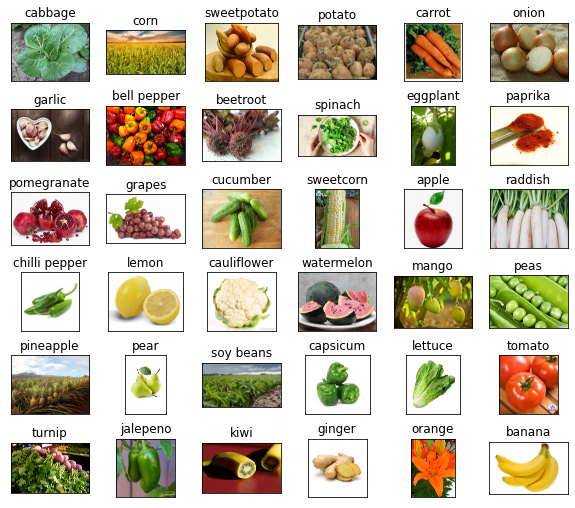

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
34/87 [==========>...................] - ETA: 22:47 - loss: 2.7902 - accuracy: 0.3173

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


87/87 [==============================] - 2511s 29s/step - loss: 1.7926 - accuracy: 0.5335 - val_loss: 0.4330 - val_accuracy: 0.8653
Epoch 2/5
87/87 [==============================] - 119s 1s/step - loss: 0.5752 - accuracy: 0.8194 - val_loss: 0.2848 - val_accuracy: 0.9072
Epoch 3/5
87/87 [==============================] - 119s 1s/step - loss: 0.3331 - accuracy: 0.8946 - val_loss: 0.2412 - val_accuracy: 0.9311
Epoch 4/5
87/87 [==============================] - 118s 1s/step - loss: 0.2204 - accuracy: 0.9295 - val_loss: 0.1962 - val_accuracy: 0.9311
Epoch 5/5
87/87 [==============================] - 118s 1s/step - loss: 0.1585 - accuracy: 0.9486 - val_loss: 0.1639 - val_accuracy: 0.9491


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


['cabbage',
 'raddish',
 'apple',
 'raddish',
 'turnip',
 'banana',
 'mango',
 'onion',
 'turnip',
 'carrot',
 'cucumber',
 'paprika',
 'sweetcorn',
 'ginger',
 'apple',
 'pineapple',
 'watermelon',
 'raddish',
 'paprika',
 'turnip',
 'bell pepper',
 'cauliflower',
 'onion',
 'pear',
 'onion',
 'watermelon',
 'sweetpotato',
 'cucumber',
 'garlic',
 'pineapple',
 'pineapple',
 'grapes',
 'pear',
 'peas',
 'tomato',
 'cucumber',
 'jalepeno',
 'bell pepper',
 'ginger',
 'sweetcorn',
 'watermelon',
 'sweetcorn',
 'raddish',
 'beetroot',
 'soy beans',
 'sweetpotato',
 'kiwi',
 'turnip',
 'carrot',
 'eggplant',
 'tomato',
 'cabbage',
 'lemon',
 'spinach',
 'lemon',
 'kiwi',
 'sweetpotato',
 'pear',
 'cucumber',
 'sweetcorn',
 'soy beans',
 'lemon',
 'lemon',
 'sweetcorn',
 'sweetpotato',
 'sweetpotato',
 'spinach',
 'onion',
 'cauliflower',
 'watermelon',
 'beetroot',
 'beetroot',
 'cabbage',
 'pomegranate',
 'cauliflower',
 'lemon',
 'mango',
 'orange',
 'banana',
 'carrot',
 'carrot',
 'ki

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
import cv2

In [ ]:
img = output('/content/drive/MyDrive/Datasets/Food & Calories Recognition/archive (1)/test/apple/Image_1.jpg')
img

'apple'

In [ ]:
model.save('FV.h5')